### Q1

#### Libraries

In [ ]:
import numpy as np
from PIL import Image, ImageOps
from matplotlib import pyplot as plt
import cv2
from tqdm import tqdm

#### Reading Images

In [ ]:
#convert image to an array and convert type from uint8 to int
image1  = np.asarray(ImageOps.grayscale(Image.open('Image1.png'))).astype('int')
image2  = np.asarray(ImageOps.grayscale(Image.open('Image2.png'))).astype('int')

(-0.5, 311.5, 414.5, -0.5)

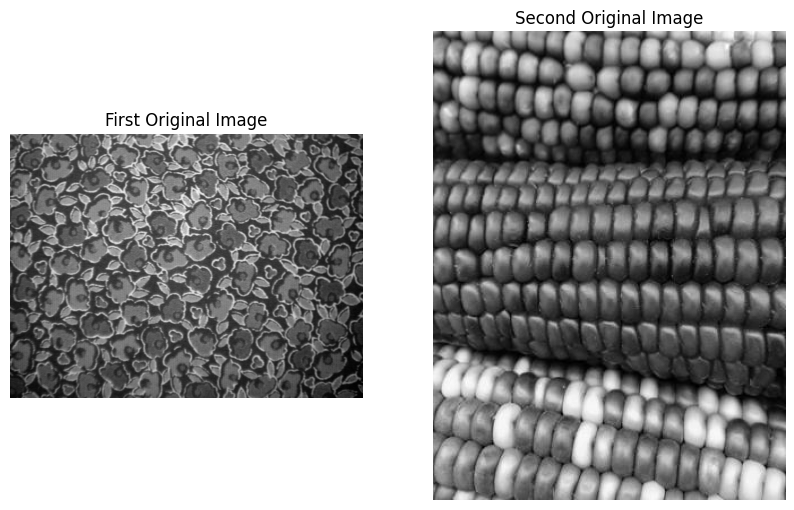

In [ ]:
fig = plt.figure(figsize=(10, 10))
rows = 1
columns = 2
fig.add_subplot(rows, columns, 1)
plt.imshow(image1.astype('uint8'),cmap = 'gray')
plt.title('First Original Image')
plt.axis('off')
fig.add_subplot(rows, columns, 2)
plt.imshow(image2.astype('uint8'),cmap = 'gray')
plt.title('Second Original Image')
plt.axis('off')


#### Adding Noies

In [ ]:
def addSaltPepper(img,percent):

      # Get the image dimensions
      rows, cols = img.shape

      # Define the probability of adding noise
      prob = percent/100

      # Create a copy of the original image
      img2 = img.copy()

      # Loop over each pixel and add noise with probability prob
      for i in range(rows):
          for j in range(cols):
              # Generate a random number
              rdn = np.random.random()
              # If the number is smaller than prob/2, set the pixel to 0 (black)
              if rdn < prob/2:
                  img2[i][j] = 0
              # If the number is larger than 1 - prob/2, set the pixel to 255 (white)
              elif rdn > 1 - prob/2:
                  img2[i][j] = 255
      return img2

In [ ]:
def gaussian(img, mean,std):

    rows, cols = img.shape
    img = img/255

    # Generate a noise array with the same shape as the image
    noise = np.random.normal(mean, std, (rows, cols))

    # Add the noise to the original image
    img_noise = img + noise
    
    return img_noise*255


In [ ]:
#Adding salt and pepper noise
image1_salt = addSaltPepper(image1,1)
image2_salt = addSaltPepper(image2,1)
#Adding gaussian noise
image1_gauss = gaussian(image1,0.5,0.1)
image2_gauss = gaussian(image2,0.5,0.1)

(-0.5, 311.5, 414.5, -0.5)

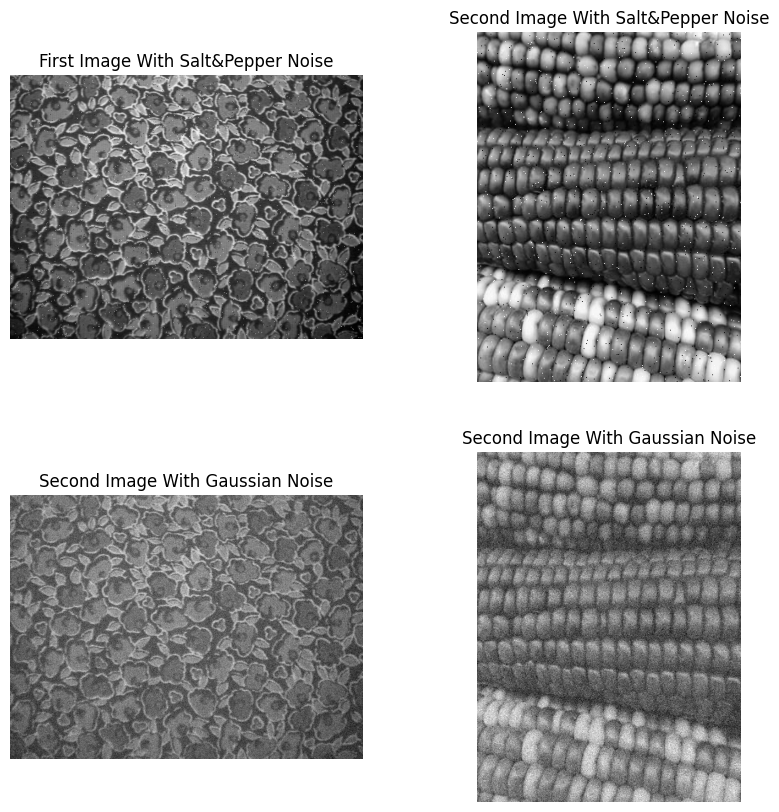

In [ ]:
fig = plt.figure(figsize=(10, 10))
rows = 2
columns = 2
fig.add_subplot(rows, columns, 1)
plt.imshow(image1_salt,cmap = 'gray')
plt.title('First Image With Salt&Pepper Noise')
plt.axis('off')
fig.add_subplot(rows, columns, 2)
plt.imshow(image2_salt,cmap = 'gray')
plt.title('Second Image With Salt&Pepper Noise')
plt.axis('off')
fig.add_subplot(rows, columns, 3)
plt.imshow(image1_gauss,cmap = 'gray')
plt.title('Second Image With Gaussian Noise')
plt.axis('off')
fig.add_subplot(rows, columns, 4)
plt.imshow(image2_gauss,cmap = 'gray')
plt.title('Second Image With Gaussian Noise')
plt.axis('off')



#### Defining Filters

In [ ]:
from scipy.ndimage import convolve

def gaussian_filter(image, kernel_size, sigma):
  # create a 2D Gaussian kernel with the given size and sigma
  k = kernel_size // 2 # half of the kernel size
  x, y = np.mgrid[-k:k+1, -k:k+1] # create a grid of coordinates
  g = np.exp(-(x**2 + y**2) / (2 * sigma**2)) # compute the Gaussian function
  g = g / g.sum() # normalize the kernel to sum to 1
  # convolve the image with the kernel using scipy.ndimage.convolve
  filtered_image = convolve(image, g, mode='reflect')
  return filtered_image

In [ ]:
def scaleImage(max_norm):
  return max(min(255, max_norm), 0)
def NLM(img, sigma=0.5 , Wsim=3,W=3):
    """
    Solve function to perform nlmeans filtering.

    :param img: noisy image
    :param sigma: sigma 
    :param Wsim: size of similarity window
    :param W: size of search window
    """
    padImg = np.pad(img,W//2,mode='reflect')
    # Calculating neighborhood window
    Nw = (sigma**2)*2

    # Getting dimensions of the image
    #h,w = img.shape

    # Initializing the result
    denoised = img - img

    # Finding width of the neighbor window and padded image from the center pixel
    WWidth = W//2
    WsimWidth = Wsim//2

    # Preprocessing the neighbors of each pixel
    neighbors = np.zeros((padImg.shape[0],padImg.shape[1],Wsim,Wsim))

    # Finding the neighbors of each pixel in the original image using the padded image
    for i in range(WWidth,WWidth + img.shape[0]):
        for j in range(WWidth,WWidth + img.shape[1]):   
            neighbors[i,j] = padImg[(i - WsimWidth):(i + WsimWidth + 1) , (j - WsimWidth):(j + WsimWidth + 1)]

    # NL Means algorithm
    for i in range(WWidth, WWidth + img.shape[0]):
        for j in range(WWidth, WWidth + img.shape[1]):
            # similarity array for pixel p
            pixelWindow = neighbors[i,j]

            # search  array for pixel p
            neighborWindow = neighbors[(i - WWidth):(i + WWidth + 1) , (j - WWidth):(j + WWidth + 1)]

            # Calculating Ip using pixelWindow and neighborWindow
            Z1 = 0
            Z2 = 0

            # Calculating distance for pixel p using neighborood pixels q
            for k in range(neighborWindow.shape[0]):
              for z in range(neighborWindow.shape[1]):
                q_window = neighborWindow[k,z]
                exp_value = np.exp(-1*((np.sum((pixelWindow - q_window)**2))/Nw))

                Z1  += (exp_value * (q_window[q_window.shape[0]//2, q_window.shape[1]//2]) )
                Z2 = Z2 + exp_value

            norm = Z1/Z2
            # Cliping the pixel values to stay between 0-255 
            denoised[i - WWidth, j - WWidth] = scaleImage(norm)
            

    return denoised 

#### Calculting PSNR

In [ ]:
def PSNR(original, noisy, peak=255):
  """ 
  param peak: max value of pixel 8-bit image (255)
  """

  # Calculating the Mean Squared Error
  mse = np.mean(np.square(original.astype('float') -  noisy.astype('float')))

  # Calculating the Peak Signal Noise Ratio
  psnr = 10*np.log10(peak**2/mse)

  return psnr

#### Applying On Images With Different Parameter

In [ ]:
def denoising(noisy_image, original_image, parameter, mode):
  PSNR_list = []
  sigma_range = [0.1 , 0.2 , 0.3 , 0.4 , 0.5]
  if(mode == 'NLM'):
      for sigma in tqdm(sigma_range) :
          denoise= NLM(noisy_image.copy(),sigma = sigma ,Wsim =3 ,W = parameter)
          PSNR_list.append(PSNR(original_image,denoise))
  elif(mode == 'gaussian'):
      for sigma in tqdm(sigma_range) :
          denoise= gaussian_filter(noisy_image.copy(),7,sigma)
          PSNR_list.append(PSNR(original_image,denoise))
  return PSNR_list

In [ ]:
PSNR_NLM_3_Image1_salt = denoising(image1_salt, image1, 3, 'NLM')
PSNR_NLM_5_Image1_salt = denoising(image1_salt, image1, 5, 'NLM')
PSNR_NLM_3_Image2_salt = denoising(image2_salt, image2, 3, 'NLM')
PSNR_NLM_5_Image2_salt = denoising(image2_salt, image2, 5, 'NLM')
PSNR_gauss_Image1_salt = denoising(image1_salt, image1, -1, 'gaussian')
PSNR_gauss_Image2_salt = denoising(image2_salt, image2, -1, 'gaussian')

PSNR_NLM_3_Image1_gauss = denoising(image1_gauss, image1, 3, 'NLM')
PSNR_NLM_5_Image1_gauss = denoising(image1_gauss, image1, 5, 'NLM')
PSNR_NLM_3_Image2_gauss = denoising(image2_gauss, image2, 3, 'NLM')
PSNR_NLM_5_Image2_gauss= denoising(image2_gauss, image2, 5, 'NLM')
PSNR_gauss_Image1_gauss = denoising(image1_gauss, image1, -1, 'gaussian')
PSNR_gauss_Image2_gauss = denoising(image2_gauss, image2, -1, 'gaussian')

100%|██████████| 5/5 [00:00<00:00, 146.08it/s]


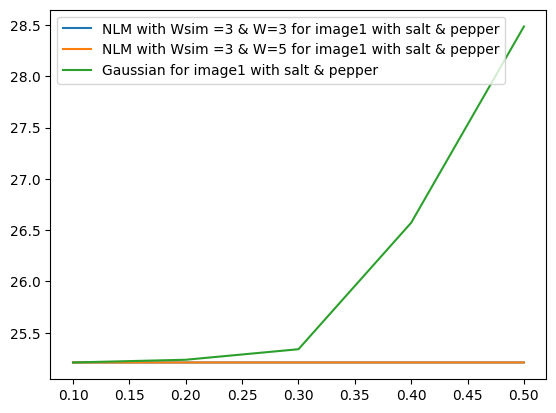

In [ ]:
sigma_range = [0.1 , 0.2 , 0.3 , 0.4 , 0.5]
plt.plot(sigma_range, PSNR_NLM_3_Image1_salt, label ='NLM with Wsim =3 & W=3 for image1 with salt & pepper')
plt.plot(sigma_range, PSNR_NLM_5_Image1_salt, label ='NLM with Wsim =3 & W=5 for image1 with salt & pepper')
plt.plot(sigma_range, PSNR_gauss_Image1_salt, label ='Gaussian for image1 with salt & pepper')
# Function add a legend  
plt.legend()
  
# function to show the plot
plt.show()

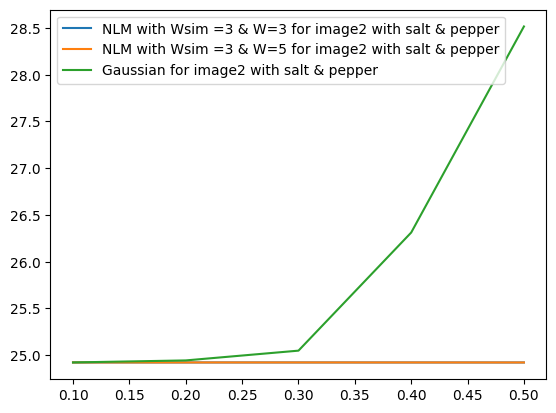

In [ ]:
sigma_range = [0.1 , 0.2 , 0.3 , 0.4 , 0.5]
plt.plot(sigma_range, PSNR_NLM_3_Image2_salt, label ='NLM with Wsim =3 & W=3 for image2 with salt & pepper')
plt.plot(sigma_range, PSNR_NLM_5_Image2_salt, label ='NLM with Wsim =3 & W=5 for image2 with salt & pepper')
plt.plot(sigma_range, PSNR_gauss_Image2_salt, label ='Gaussian for image2 with salt & pepper')
# Function add a legend  
plt.legend()
  
# function to show the plot
plt.show()

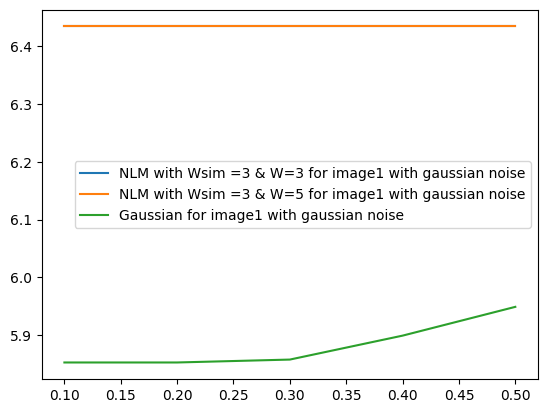

In [ ]:
sigma_range = [0.1 , 0.2 , 0.3 , 0.4 , 0.5]
plt.plot(sigma_range, PSNR_NLM_3_Image1_gauss, label ='NLM with Wsim =3 & W=3 for image1 with gaussian noise')
plt.plot(sigma_range, PSNR_NLM_5_Image1_gauss, label ='NLM with Wsim =3 & W=5 for image1 with gaussian noise')
plt.plot(sigma_range, PSNR_gauss_Image1_gauss, label ='Gaussian for image1 with gaussian noise')
# Function add a legend  
plt.legend()
  
# function to show the plot
plt.show()

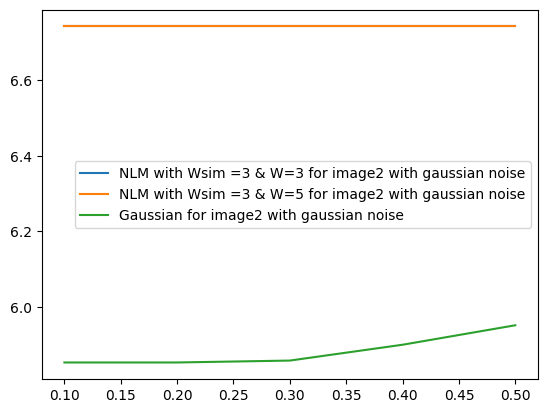

In [ ]:
sigma_range = [0.1 , 0.2 , 0.3 , 0.4 , 0.5]
plt.plot(sigma_range, PSNR_NLM_3_Image2_gauss, label ='NLM with Wsim =3 & W=3 for image2 with gaussian noise')
plt.plot(sigma_range, PSNR_NLM_5_Image2_gauss, label ='NLM with Wsim =3 & W=5 for image2 with gaussian noise')
plt.plot(sigma_range, PSNR_gauss_Image2_gauss, label ='Gaussian for image2 with gaussian noise')
# Function add a legend  
plt.legend()
  
# function to show the plot
plt.show()

(-0.5, 639.5, 479.5, -0.5)

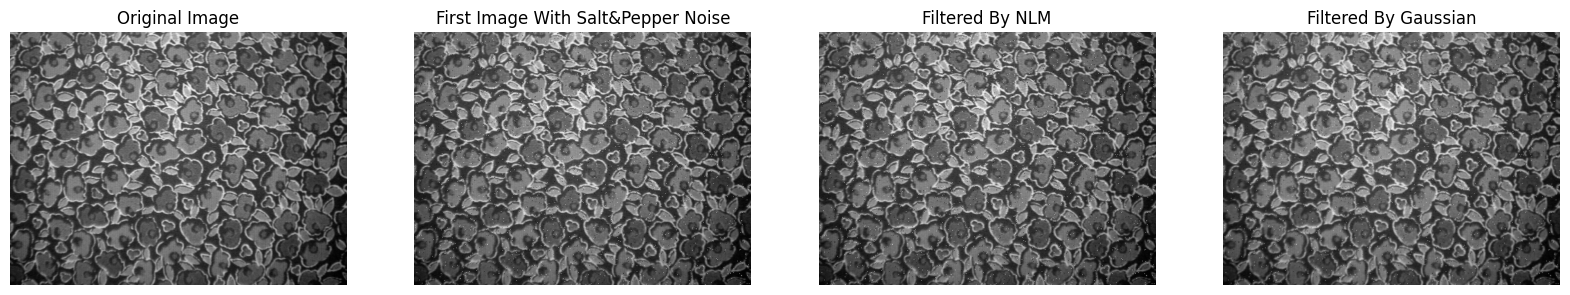

In [ ]:
fig = plt.figure(figsize=(20, 20))
rows = 1
columns = 4
fig.add_subplot(rows, columns, 1)
plt.imshow(image1.astype('uint8'),cmap='gray' )
plt.title('Original Image')
plt.axis('off')
fig.add_subplot(rows, columns, 2)
plt.imshow(image1_salt.astype('uint8'),cmap = 'gray' )
plt.title('First Image With Salt&Pepper Noise')
plt.axis('off')
fig.add_subplot(rows, columns, 3)
plt.imshow(NLM(image1_salt.copy(),sigma = 0.5 ,Wsim =3 ,W = 5).astype('uint8'),cmap='gray' )
plt.title('Filtered By NLM')
plt.axis('off')
fig.add_subplot(rows, columns, 4)
plt.imshow(gaussian_filter(image1_salt.copy(),7,0.5).astype('uint8') ,cmap='gray' )
plt.title('Filtered By Gaussian')
plt.axis('off')


(-0.5, 311.5, 414.5, -0.5)

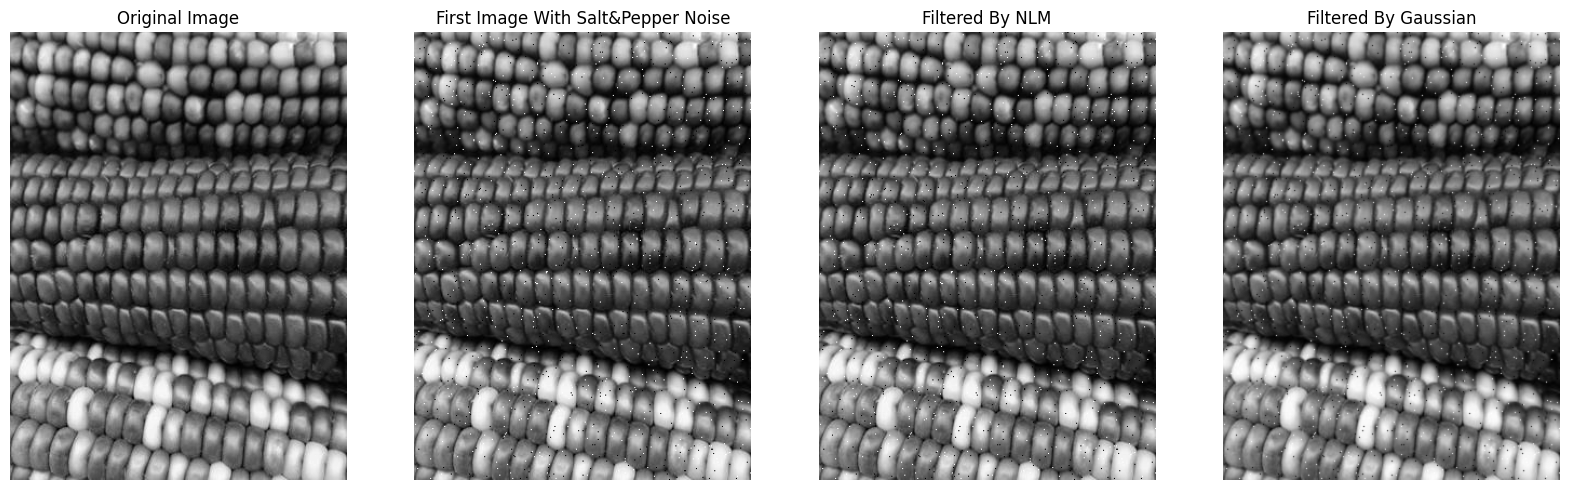

In [ ]:
fig = plt.figure(figsize=(20, 20))
rows = 1
columns = 4
fig.add_subplot(rows, columns, 1)
plt.imshow(image2.astype('uint8'),cmap='gray' )
plt.title('Original Image')
plt.axis('off')
fig.add_subplot(rows, columns, 2)
plt.imshow(image2_salt.astype('uint8'),cmap = 'gray' )
plt.title('First Image With Salt&Pepper Noise')
plt.axis('off')
fig.add_subplot(rows, columns, 3)
plt.imshow(NLM(image2_salt.copy(),sigma = 0.5 ,Wsim =3 ,W = 3).astype('uint8'),cmap='gray' )
plt.title('Filtered By NLM')
plt.axis('off')
fig.add_subplot(rows, columns, 4)
plt.imshow(gaussian_filter(image2_salt.copy(),7,0.5).astype('uint8') ,cmap='gray' )
plt.title('Filtered By Gaussian')
plt.axis('off')


(-0.5, 639.5, 479.5, -0.5)

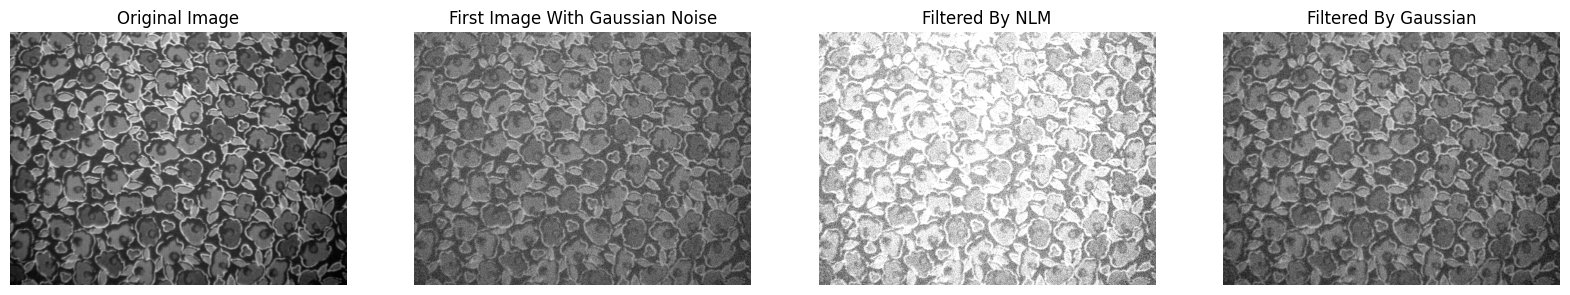

In [ ]:
fig = plt.figure(figsize=(20, 20))
rows = 1
columns = 4
fig.add_subplot(rows, columns, 1)
plt.imshow(image1.astype('uint8'),cmap='gray' )
plt.title('Original Image')
plt.axis('off')
fig.add_subplot(rows, columns, 2)
plt.imshow(image1_gauss,cmap = 'gray' )
plt.title('First Image With Gaussian Noise')
plt.axis('off')
fig.add_subplot(rows, columns, 3)
plt.imshow(NLM(image1_gauss.copy(),sigma = 0.5 ,Wsim =3 ,W = 3),cmap='gray' )
plt.title('Filtered By NLM')
plt.axis('off')
fig.add_subplot(rows, columns, 4)
plt.imshow(gaussian_filter(image1_gauss.copy(),7,0.5) ,cmap='gray' )
plt.title('Filtered By Gaussian')
plt.axis('off')


(-0.5, 311.5, 414.5, -0.5)

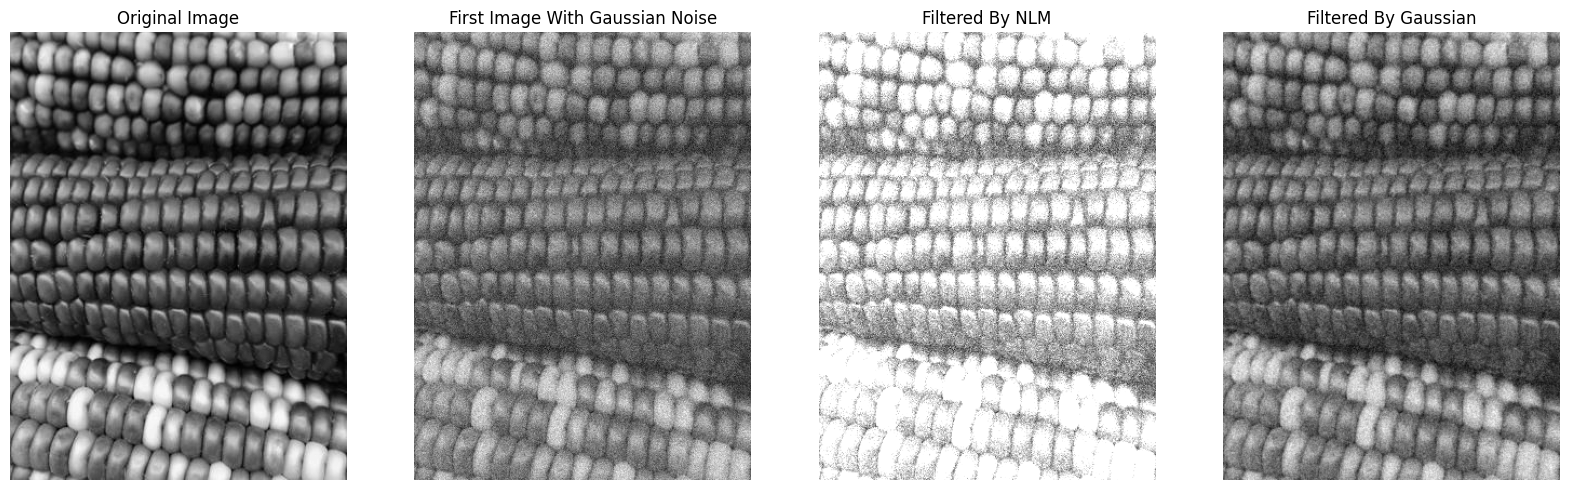

In [ ]:
fig = plt.figure(figsize=(20, 20))
rows = 1
columns = 4
fig.add_subplot(rows, columns, 1)
plt.imshow(image2.astype('uint8'),cmap='gray' )
plt.title('Original Image')
plt.axis('off')
fig.add_subplot(rows, columns, 2)
plt.imshow(image2_gauss,cmap = 'gray' )
plt.title('First Image With Gaussian Noise')
plt.axis('off')
fig.add_subplot(rows, columns, 3)
plt.imshow(NLM(image2_gauss.copy(),sigma = 0.5 ,Wsim =3 ,W = 3),cmap='gray' )
plt.title('Filtered By NLM')
plt.axis('off')
fig.add_subplot(rows, columns, 4)
plt.imshow(gaussian_filter(image2_gauss.copy(),7,0.5) ,cmap='gray' )
plt.title('Filtered By Gaussian')
plt.axis('off')


NLM filter is a non-linear filter that uses a weighted average of pixels in a local neighborhood to reduce noise in an image. It works by comparing the similarity between two patches of pixels in an image and then averaging them based on their similarity. NLM filter supports the comparison of regions rather than pixel comparison.

On the other hand, Gaussian filter is a linear filter that uses a Gaussian function to blur an image. It works by convolving an image with a Gaussian kernel to produce a smoothed version of the original image.

In summary, NLM filter is more effective than Gaussian filter in reducing noise in an image because it takes into account the similarity between regions rather than just pixel comparison. However, it is computationally expensive compared to Gaussian filter.


---
In practice it seems that NLM filter is more effective than Gaussian filter in reducing Gaussian noise in an image while blurring less than Gaussian filter. On the other hand, Gaussian filter works better for salt and pepper noise.
